In [29]:
import numpy as np
# from numpy.lib.type_check import imag
import tensorflow as tf
import keras.layers as layers

import datetime
import time

from tensorboardX import SummaryWriter
from tensorflow.python.platform import tf_logging as logging
# from tensorflow_probability import distributions as tfd
from absl import app
from absl import flags

# from data.visualization import *
from utils import *
from models import perception as pc
# from models import dynamics as dy
import loss 
from train_vae import *
import matplotlib.pyplot as plt

In [30]:
def concat_frames_horizontally(v):
  """Arrange a video as horizontally aligned frames."""
  num_frames = v.shape[0]
  # num_frames = 5
  # [F, H, W, C] --> [H, W*F, C].
  return np.concatenate([v[x] for x in range(num_frames)], axis=1)

def describe(d):
  """Describe the contents of a dict of np arrays."""
  for k, v in d.items():
    print(f'\'{k}\' has shape: {v.shape}')
    print(f'===================')
    print(f'min: {v.min()}, max: {v.max()}, type: {v.dtype}\n')

def colorize_mask(m):
  """Adds color channel to mask of unique object ids."""
  """
  input: m: [num_frames,height, width]
  """
  c_m = np.expand_dims(m, axis=-1)
  # c_m = np.squeeze(c_m)
  min_val = np.max(c_m)
  max_val = np.min(c_m)
  # Use three different mappings into range [0-1] to form color.
  c1 = (c_m - min_val)/(max_val - min_val)
  c2 = np.abs((c_m - max_val)/(min_val - max_val))
  c3 = (c1+c2)/2.
  mask = np.concatenate([c1, c2, c3], axis=-1)
  return mask

def colorize_segmask(m):
  """
  add color channel to mask of 

  Args:
      m (num_frames,height, width, num_slots): mask after one-hot encoding
  """
  t, h, w, n = m.shape
  value = tf.constant(range(n), dtype = tf.float32)
  value = tf.expand_dims(tf.expand_dims(tf.expand_dims(value, axis = 0),axis=0),axis=0)
  value = tf.tile(value, multiples=[t, h, w, 1])
  m = m * value
  m = tf.reduce_sum(m, axis = -1)
  return colorize_mask(m)
    

def plot_video(v, name=''):
  """Plots something of the form [num_frames, height, width, channel]."""
  num_frames = v.shape[0]
  width = v.shape[2]
  v = concat_frames_horizontally(v)
  plt.figure(figsize=(30,5))
  plt.imshow(v)
  plt.xticks(ticks=[i*width+width/2 for i in range(num_frames)],
            labels=range(1,num_frames+1))
  plt.yticks([])
  plt.xlabel('Frame Number')
  plt.title(name)
  plt.show()

In [31]:
test_ds = make_freeform_tfrecord_dataset(is_train = False)
iterator = iter(test_ds)
freeform_generator = test_ds.as_numpy_iterator()
freeform_example = next(freeform_generator)
# freeform_example = next(freeform_generator)
print(freeform_example.keys())

dict_keys(['camera_pose', 'image', 'mask'])


In [32]:
freeform_example = next(freeform_generator)

In [33]:
perception = pc.ComponentVAE(input_channels = 3, height= 64, width = 64, latent_dim = 16)
ckpt_e = tf.train.Checkpoint(network=perception)
ckpt_manager_e = tf.train.CheckpointManager(checkpoint=ckpt_e,
                                          directory="/home/stu4/wlg/PLATO/checkpoint/perception/num_slot_8/slot_size_16_learning_rate_0.0004_",
                                          max_to_keep = 5)
checkpoint_path = "/home/stu4/wlg/PLATO/checkpoint/perception"
ckpt_e.restore(ckpt_manager_e.latest_checkpoint)

In [34]:
def mask_seg(mask):
    """
    preprocess the mask to get the K channels mask for K objects
    input: mask (batch_size, height, width)
    output: mask_seg (batch_size,  height, width, K)
    in our case, K = 8
    """
    mask_seg = tf.one_hot(indices=mask, depth = 8, on_value=1.0, off_value=0.0, axis = 0)
    mask_seg = tf.transpose(mask_seg, perm=[1,2,3,0])
    # print("one-hot mask:", mask_seg.shape)
    return mask_seg

In [35]:
image_test = freeform_example['image']
mask = freeform_example['mask']
print("mask",mask.shape)
print(image_test.shape)

mask (15, 64, 64)
(15, 64, 64, 3)


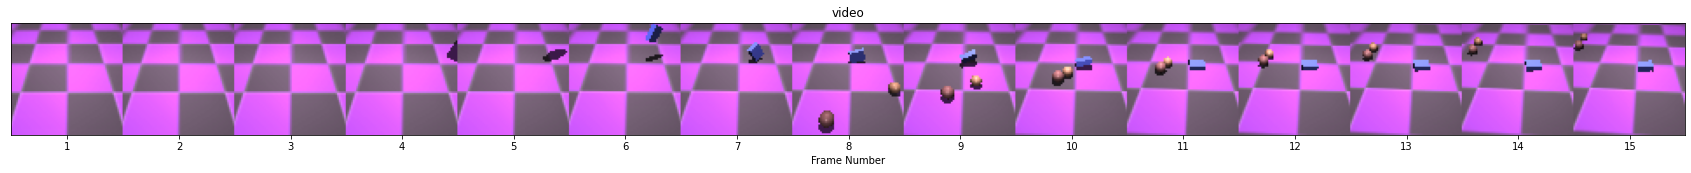

In [36]:
plot_video(image_test, name = "video")

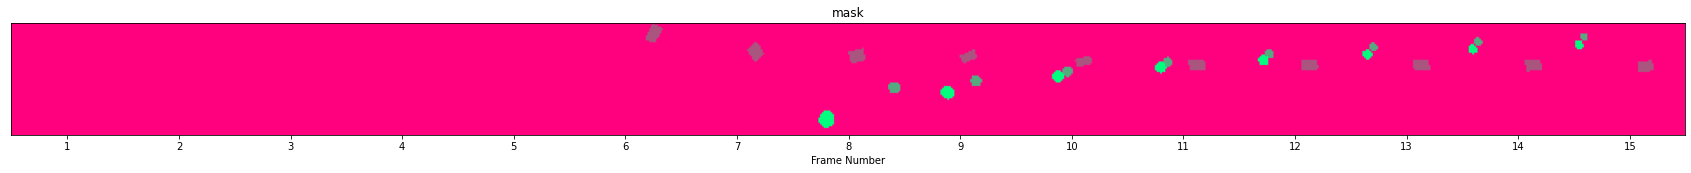

In [37]:
mask = mask_seg(mask)
mask = tf.cast(mask, tf.float32)
plot_video(colorize_segmask(mask), name = "mask")

In [38]:
batch = freeform_example
image = batch['image']
image = tf.cast(image, tf.float32)
image = image / 255.0
image_b = tf.reshape(image, [-1, 64,64,3])

mask = batch['mask']
print("mask:",batch['mask'].shape)
mask  = mask_seg(mask)
mask = tf.cast(mask, tf.float32)
print("mask:",mask.shape)
# mask = tf.reshape(mask, [-1, 64, 64, 8])
# pred_video, pred_mask, logvar, mean, z_sample = perception(image, mask)
image = tf.expand_dims(image, axis = 0)
mask = tf.expand_dims(mask, axis = 0)
latent_code = pc.video_encoding(perception, image, mask)
pred_video, pred_mask = pc.video_decoding(perception, latent_code)  

mask: (15, 64, 64)
mask: (15, 64, 64, 8)


In [39]:
print("pred_video:", pred_video.shape)
print("pred_mask:", pred_mask.shape)
print("max_value in video:",tf.reduce_max(pred_video))

pred_video: (1, 15, 64, 64, 3, 8)
pred_mask: (1, 15, 64, 64, 8)
max_value in video: tf.Tensor(1.0, shape=(), dtype=float32)


In [40]:
reconst = tf.reduce_sum(pred_video, axis = -1)
reconst = tf.reshape(reconst, [-1, 64, 64, 3])
image = tf.reshape(image, [-1, 64, 64, 3])
construction_error = loss.l2_loss(reconst, image)
print("construction_error1:", construction_error)

construction_error1: tf.Tensor(0.0030213408, shape=(), dtype=float32)


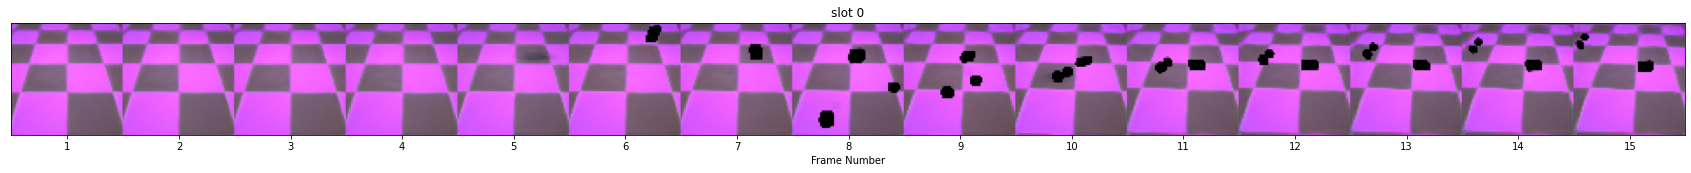

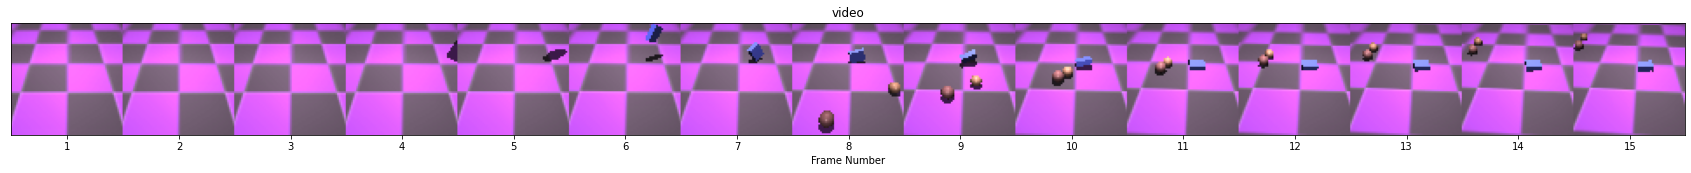

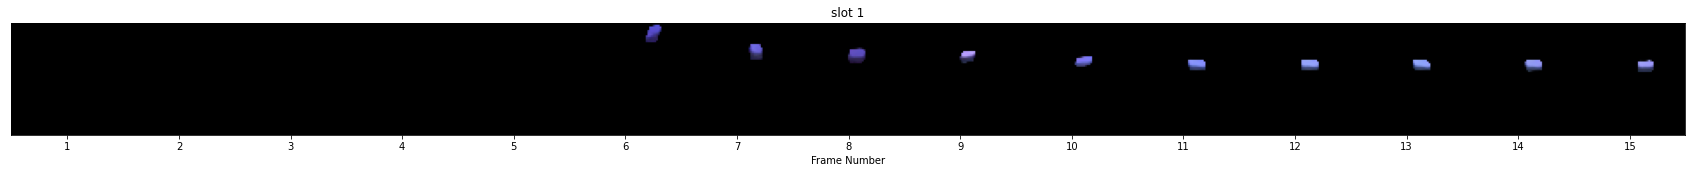

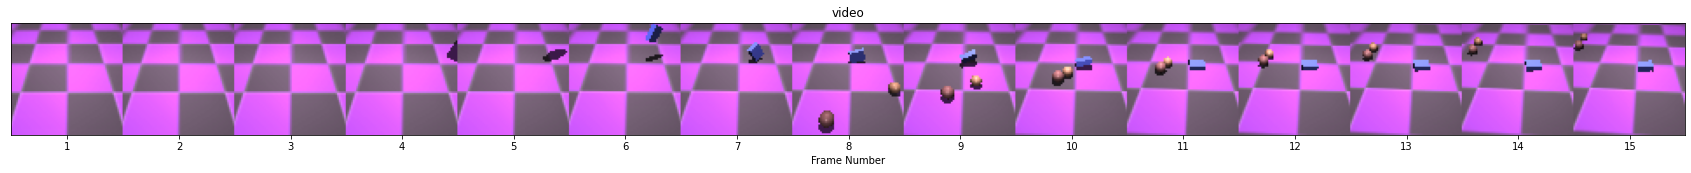

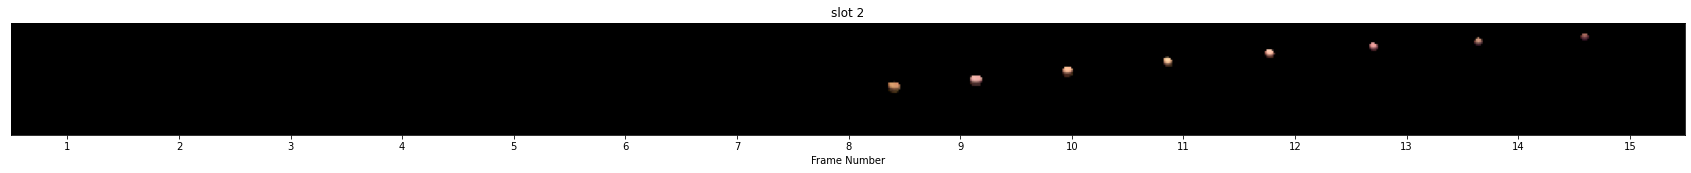

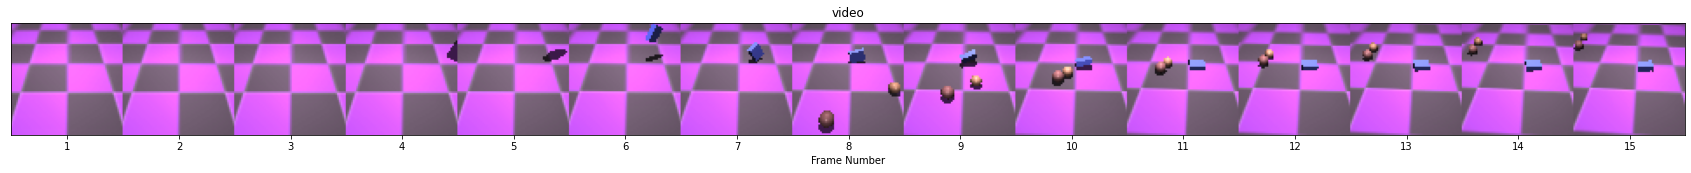

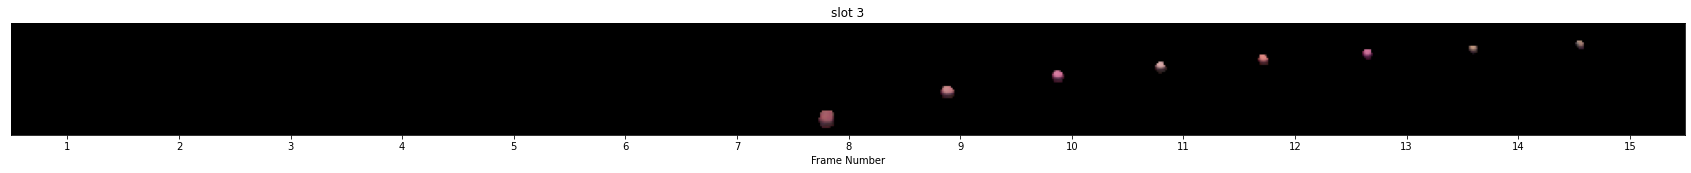

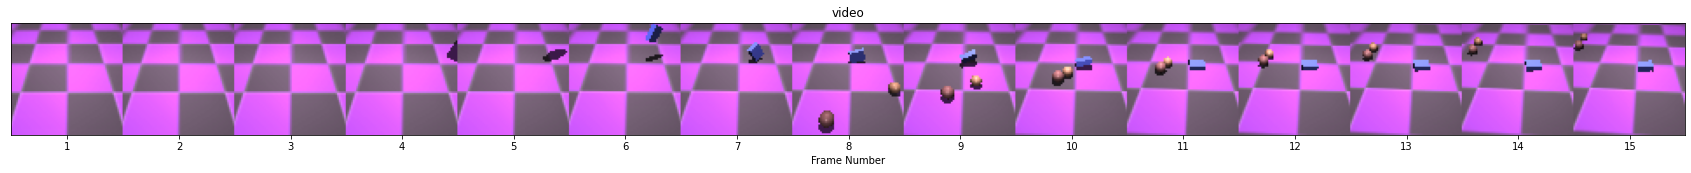

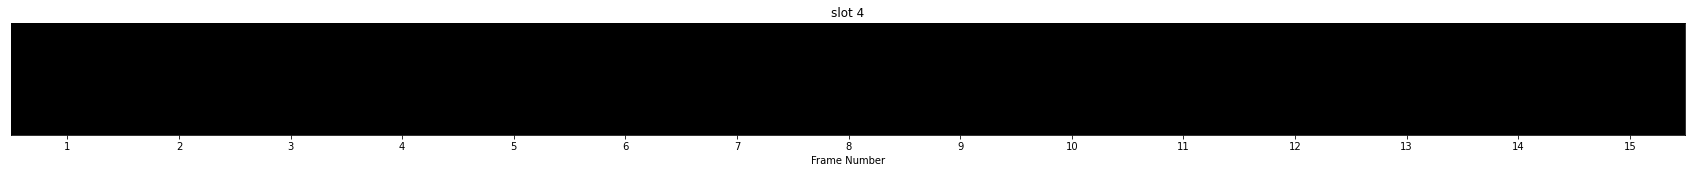

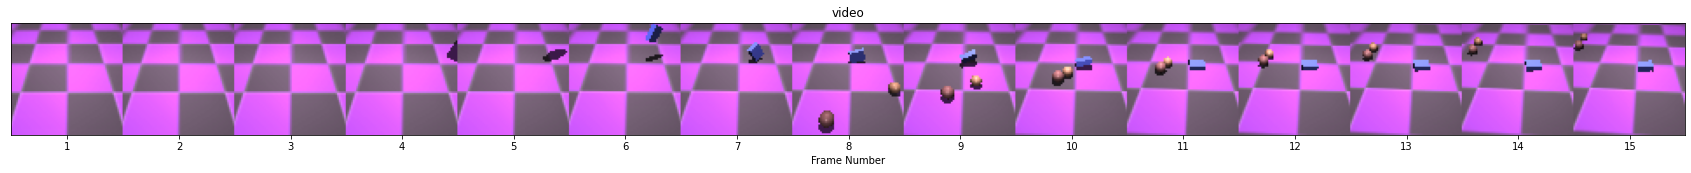

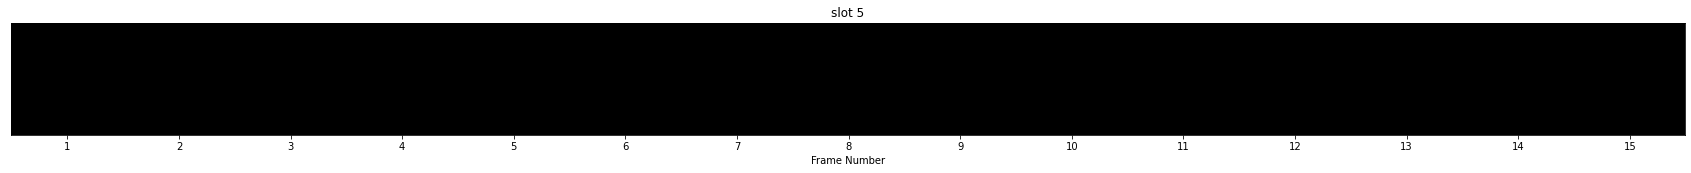

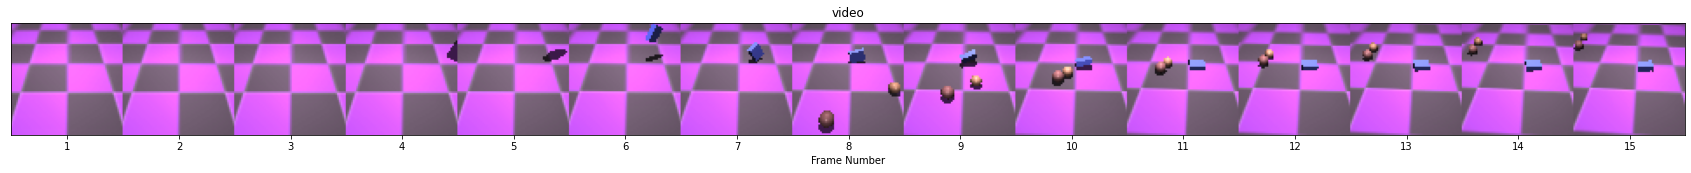

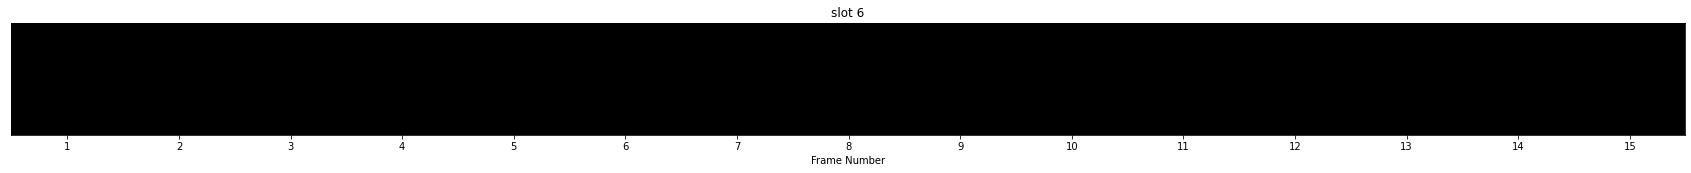

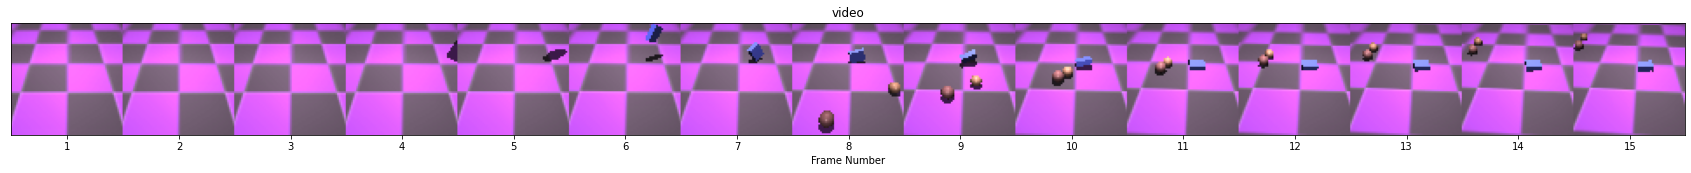

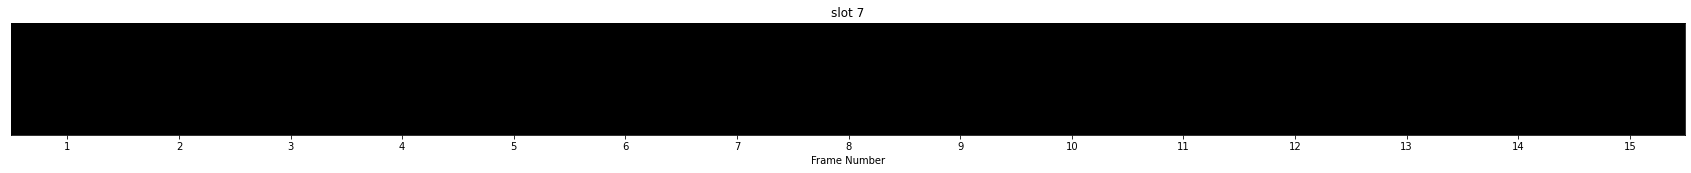

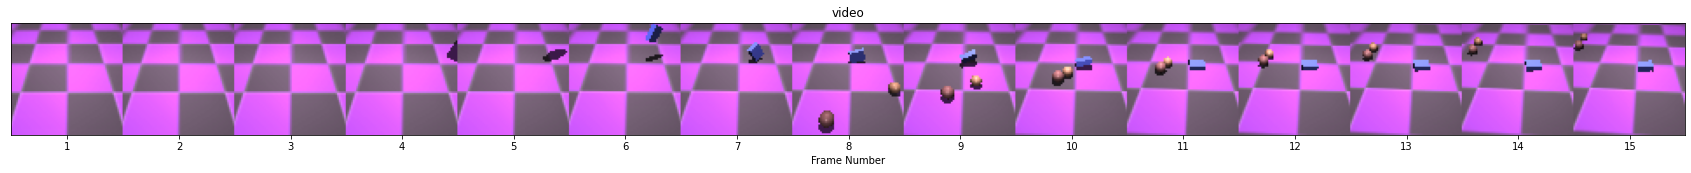

In [41]:

for i in range(8):
    plot_video(pred_video[0, :, :, :, :, i], name = "slot {}".format(i))
    plot_video(image_test, name = "video")

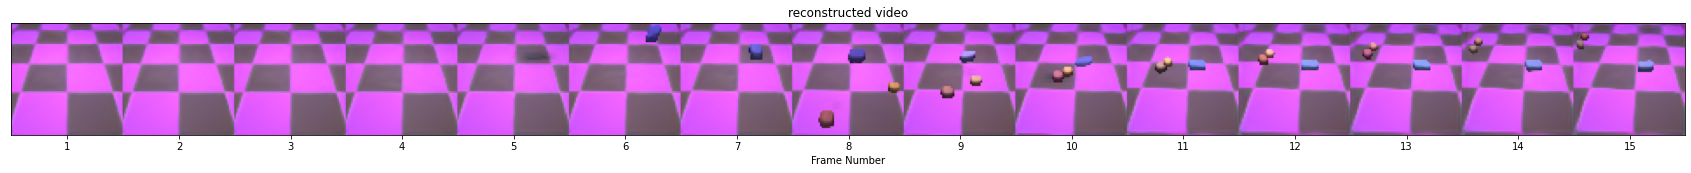

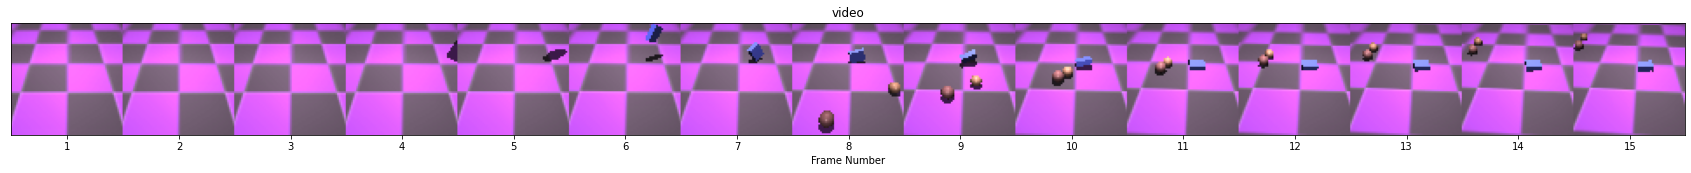

In [42]:
plot_video(tf.reduce_sum(pred_video[0], axis = -1), name = "reconstructed video")
plot_video(image_test, name = "video")

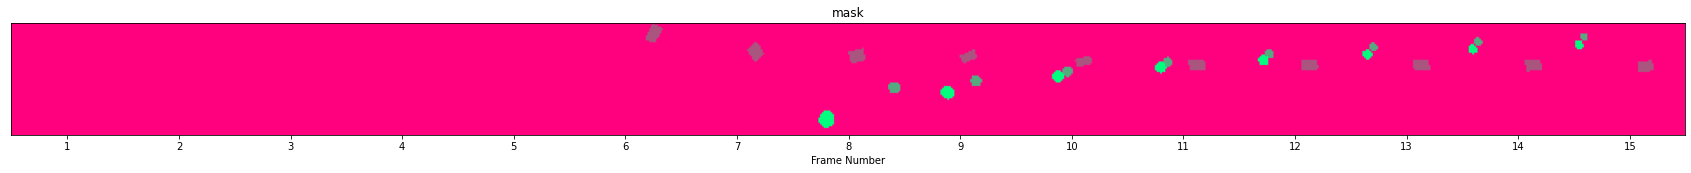

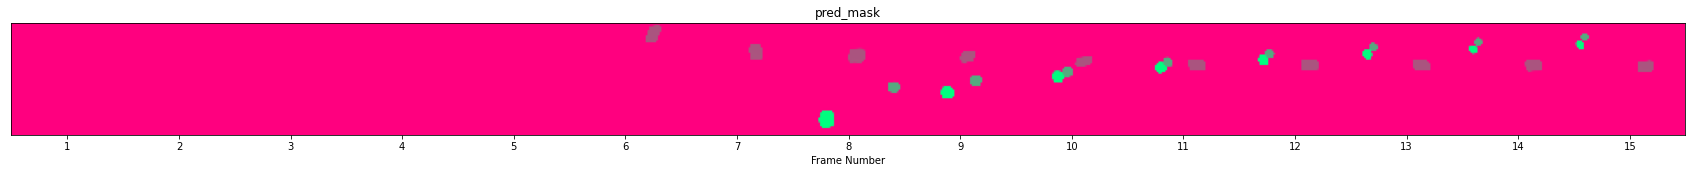

: 

In [43]:
plot_video(colorize_segmask(mask[0]), name = "mask")
plot_video(colorize_segmask(pred_mask[0]), name = "pred_mask")